In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.models_original as models_original
import models.models_3d_atomics as models_3d_atomics
import models.models_3d as models_3d
from models.data import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_forward_selection, get_top_features_per_concept

device = get_free_gpu()

current device cuda:15


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [3]:
print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)


27 8 6


In [4]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
conf_matrix = ConfusionMatrix(task="binary").to(device)

## Optimization

In [5]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original/"

def get_model(random_seed):
    set_seed(random_seed)
    config_original = {
        "n_concepts": 4,
        "use_indicators": True,
    }
    
    makedir(experiment_folder)
    model_path = get_filename_from_dict(experiment_folder, config_original)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)

    model = models_original.CBM(**config_original, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, device=device)
    # model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_original, seed = random_seed), max_epochs=10000)
    # init lazy layers
    with torch.no_grad():
        for batch in train_loader:
            *data, y_true = extract_to(batch, model.device)
            model(*data)
    
    model.fit(train_loader, val_loader, class_weights, max_epochs=1000, sparse_fit=True)
    
    evaluate_classification(model, test_loader)
    return model

# model = get_model(1)

In [6]:
models = [get_model(random_seed) for random_seed in range(1,4)]

for model in models:
    total = model.bottleneck.weight.numel()
    zeros_per = (model.bottleneck.weight == 0).sum(dim=1)
    zeros = zeros_per.sum().item()
    not_zeros_per = (model.bottleneck.weight != 0).sum(dim=1)
    not_zeros = not_zeros_per.sum().item()
    print(total, zeros/total, not_zeros/total, zeros_per, zeros, not_zeros_per, not_zeros)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Removing biases...
Removed 1 layers.
Removing 2D batch norms...
Removing 1D batch norms...
weight 118
Prune rate: 0.5

Total Model parameters: 2628
Total parameters after removed layers: 2624
Total parameters under sparsity level of 0.05: 131.20000000000002


  0%|          | 0/1000 [00:00<?, ? epoch/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
 47%|████▋     | 470/1000 [06:35<07:25,  1.19 epoch/s, Train Loss=0.47723, Val Loss=0.51625, Best Val Loss=0.51550]

Early Stopped


AUC macro 0.917
ACC macro 0.841
 F1 macro 0.849


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Removing biases...
Removed 1 layers.
Removing 2D batch norms...
Removing 1D batch norms...
weight 143
Prune rate: 0.5

Total Model parameters: 2628
Total parameters after removed layers: 2624
Total parameters under sparsity level of 0.05: 131.20000000000002


  0%|          | 0/1000 [00:00<?, ? epoch/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
 45%|████▌     | 450/1000 [06:09<07:31,  1.22 epoch/s, Train Loss=0.48058, Val Loss=0.50914, Best Val Loss=0.50773]

Early Stopped


AUC macro 0.921
ACC macro 0.847
 F1 macro 0.854


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Removing biases...
Removed 1 layers.
Removing 2D batch norms...
Removing 1D batch norms...
weight 128
Prune rate: 0.5

Total Model parameters: 2628
Total parameters after removed layers: 2624
Total parameters under sparsity level of 0.05: 131.20000000000002


  0%|          | 0/1000 [00:00<?, ? epoch/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
 67%|██████▋   | 670/1000 [09:47<04:49,  1.14 epoch/s, Train Loss=0.47995, Val Loss=0.50059, Best Val Loss=0.50032]

Early Stopped


AUC macro 0.916
ACC macro 0.839
 F1 macro 0.847
2624 0.9554115853658537 0.04458841463414634 tensor([643, 642, 618, 604], device='cuda:15') 2507 tensor([13, 14, 38, 52], device='cuda:15') 117
2624 0.9561737804878049 0.04382621951219512 tensor([655, 604, 636, 614], device='cuda:15') 2509 tensor([ 1, 52, 20, 42], device='cuda:15') 115
2624 0.9523628048780488 0.04763719512195122 tensor([652, 599, 629, 619], device='cuda:15') 2499 tensor([ 4, 57, 27, 37], device='cuda:15') 125


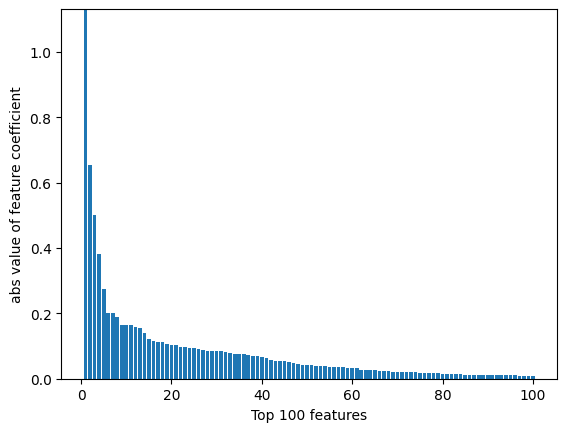

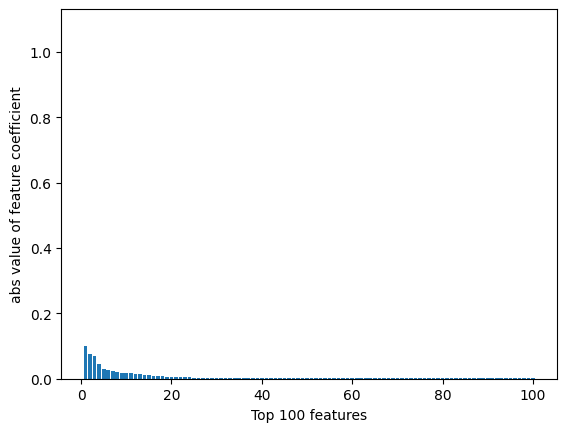

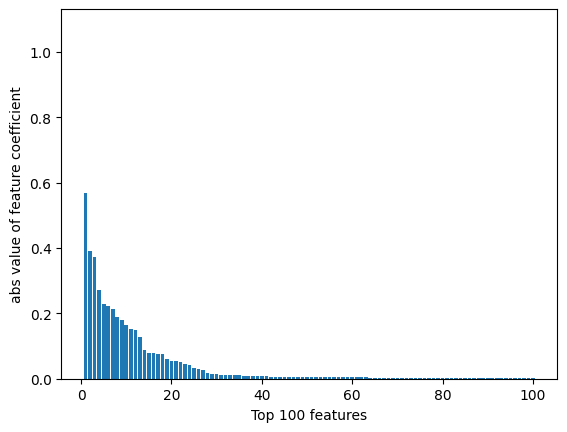

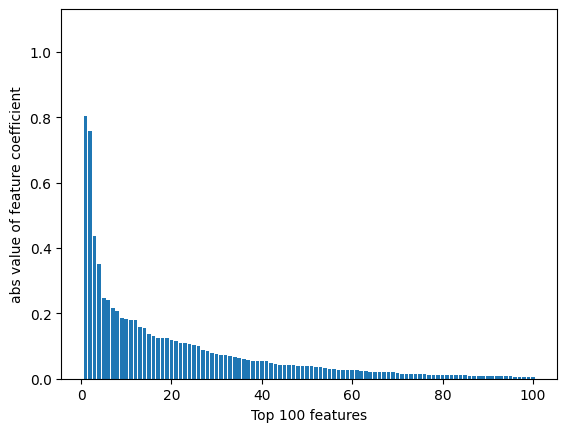

In [76]:
visualize_top100_weights_per_channel(model.bottleneck)


In [77]:
top_k_inds = get_top_features_per_concept(model.bottleneck)
# top_k_inds
model.layer_output.weight

Found 4 Concepts
90th percentile per concept [8.141751  0.8794138 4.321822  7.642881 ]
['Concept 0 len: 79', 'Concept 1 len: 272', 'Concept 2 len: 77', 'Concept 3 len: 71']


Parameter containing:
tensor([[-2.9332, -0.7390,  1.6230,  2.7394],
        [ 2.9472,  0.8819, -1.5301, -2.7543]], device='cuda:15',
       requires_grad=True)

In [29]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)

track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

models = [get_model(seed) for seed in range(1,4)]

results = []
for seed, model in enumerate(models, 1):
    print("seed", seed)
    top_k_inds = get_top_features_per_concept(model.bottleneck)
    
    greedy_results = greedy_forward_selection(model=model, layers_to_prune=[model.bottleneck], top_k_inds=[top_k_inds], val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics)
    greedy_results['Merged'] = greedy_results['Layer'].astype(str) + '_' + greedy_results['Concept'].astype(str) + '_' + greedy_results['Feature'].astype(str)
    results.append(greedy_results)
    
    top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds_seed_{seed}.csv".format(seed=seed)

    write_df_2_csv(top_k_csv_file, greedy_results)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original_new/n_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_1.pt
AUC macro 0.9131898880004883
ACC macro 0.8352497220039368
 F1 macro 0.8434697389602661


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original_new/n_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_2.pt
AUC macro 0.9151526093482971
ACC macro 0.8385961651802063
 F1 macro 0.846611738204956


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original_new/n_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_3.pt
AUC macro 0.9143695831298828
ACC macro 0.8337909579277039
 F1 macro 0.8420966863632202
1
2
Found 4 Concepts
90th percentile per concept [7.7694016 1.8362296 3.104334  7.6339426]
['Concept 0 len: 80', 'Concept 1 len: 146', 'Concept 2 len: 122', 'Concept 3 len: 83']


 15%|█▌        | 6/40 [19:40<1:51:02, 195.94s/it, Score=0.91522, acc=0.863, f1=0.865, auc=0.915]

In [78]:
greedy_results = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/original_new/top-k/bottleneck_topkinds_1.csv")


In [83]:
pd.set_option('display.max_rows', 100)
greedy_results

model.deactivate_bottleneck_weights_if_top_k(greedy_results)

In [14]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds.csv" #_r{}_c{}   .format(random_seed, n_concepts)

write_df_2_csv(top_k_csv_file, greedy_results)


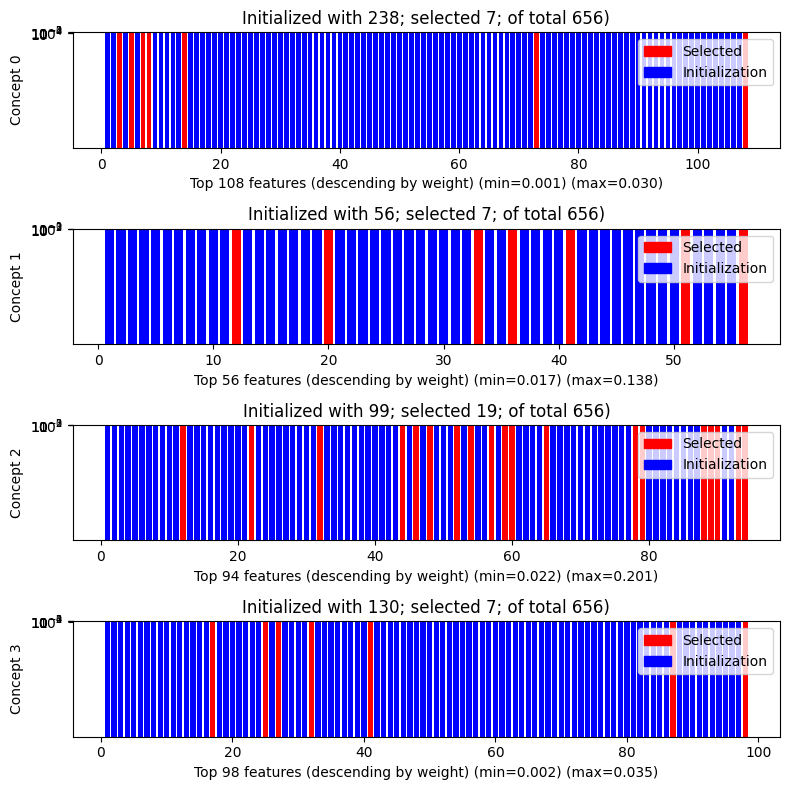

In [50]:

def plot_selected_weights(weight, top_k_inds, greedy_results, top_k=100):
    abs_weight = weight.detach().cpu().numpy()
    abs_weight = np.abs(abs_weight)
    
    n_concepts = abs_weight.shape[0]
    max_y = np.max(abs_weight)
    
    fig, axs = plt.subplots(n_concepts, figsize=(8, 2 * n_concepts))
    
    for c in range(n_concepts):
        ax = axs[c]
        
        init_features_idx = top_k_inds[c]
        selected_features_idx = greedy_results[greedy_results["Concept"] == c]["Feature"].to_list()
        # print(selected_features_idx)
        
        min_weight = np.min(abs_weight[c][selected_features_idx])
        max_weight = np.max(abs_weight[c][selected_features_idx])
        weight_idx = np.argsort(-abs_weight[c])
        weight_idx = weight_idx[abs_weight[c][weight_idx] >= min_weight]
        n_rel_feat = len(weight_idx)
        
        # weight_idx = np.argsort(-abs_weight[c])[:top_k]
        
        def getColor(idx):
            if idx in selected_features_idx:
                return "red"
            elif idx in init_features_idx:
                return "blue"
            else:
                return "gray"
        
        colors = [getColor(idx) for idx in weight_idx]
        ax.bar(np.arange(1, len(weight_idx)+1), abs_weight[c][weight_idx], color=colors)
        
        ax.set_title(f"Initialized with {len(init_features_idx)}; selected {len(selected_features_idx)}; of total {len(abs_weight[c])})")
        ax.set_xlabel(f"Top {n_rel_feat} features (descending by weight) (min={min_weight:.3f}) (max={max_weight:.3f})")
        ax.set_ylabel(f"Concept {c}")
        ax.set_ylim(0, max_y)
        ax.set_yscale('log')
        
        leg_handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['red', 'blue']] # , 'gray'
        leg_labels = ["Selected", "Initialization"] # , "Ignored"
        ax.legend(leg_handles, leg_labels)
    
    # plt.ylabel("abs value of feature coefficient")
    plt.tight_layout()
    plt.show()

plot_selected_weights(model.bottleneck.weight, top_k_inds, greedy_results, 250)

torch.Size([4, 656, 3])


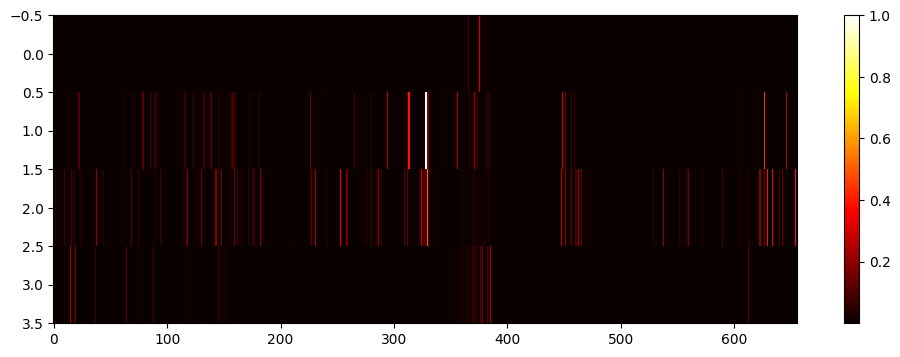

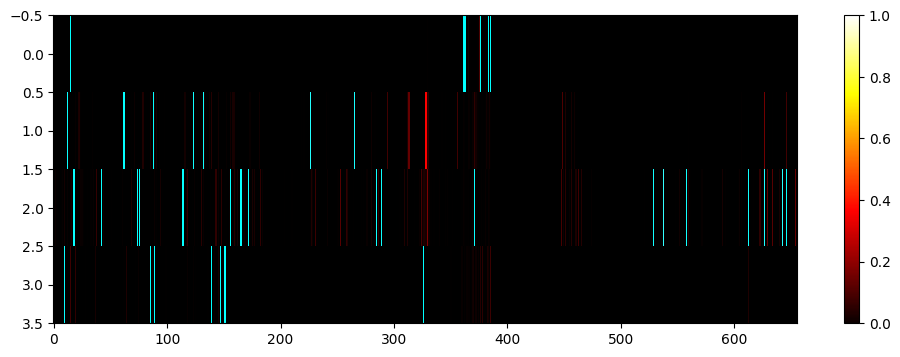

1.0

In [93]:
mask = torch.zeros(model.bottleneck.weight.size(), dtype=torch.float)

for c, f in zip(results[0]["Concept"], results[0]["Feature"]):
    mask[c,f] = 1

weight = torch.abs(model.bottleneck.weight.detach().cpu())
weight = weight / torch.max(weight)

test = torch.stack([weight, mask, mask], dim=-1)
print(test.shape)

for df in results:
    plt.figure(figsize=(12, 4))
    plt.imshow(weight, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.imshow(test, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.show()
    
    break
    
selected_feats = [df["Merged"].to_list() for df in results]
jaccard_similarity(*selected_feats)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original_new/n_concepts_4_use_indicators_True_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845
AUC macro 0.914
ACC macro 0.839
 F1 macro 0.846
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845
AUC macro 0.874
ACC macro 0.848
 F1 macro 0.853


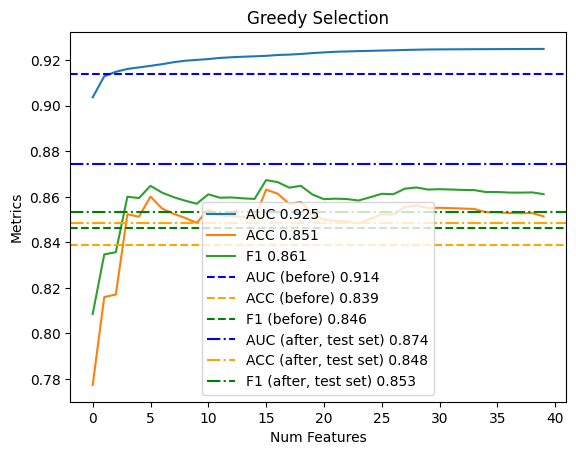

In [90]:
model = get_model(1)
greedy_results = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/original_new/top-k/bottleneck_topkinds_1.csv")
train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

visualize_optimization_results(model, val_loader, test_loader, greedy_results)
